## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 6-2. Modeling 2 - WS 64 Seed - Logistic Regression

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5-1. Modeling (1) RPI prediction based on stats - XGboost regression
- Step 5-2. Modeling (1) RPI prediction based on stats - Linear regression
- Step 6-1. Modeling (2) WS 64 Seed prediction based on stats - XGboost classification
- Step 6-2. Modeling (2) WS 64 Seed prediction based on stats - Logistic regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [2]:
y_WSin = pd.read_csv('Data/y_WSin.csv')
y_WSin_2019 = pd.read_csv('Data/y_WSin_2019.csv')

X = pd.read_csv('Data/X.csv')
X_2019 = pd.read_csv('Data/X_2019.csv')
X_famd = pd.read_csv('Data/X_famd.csv')
X_famd_2019 = pd.read_csv('Data/X_famd_2019.csv')
X_College = pd.read_csv('Data/X_College.csv')
X_College_2019 = pd.read_csv('Data/X_College_2019.csv')

In [13]:
X_famd_ext = pd.concat([X_famd,X.iloc[:,15:49]], axis=1)
X_famd_2019_ext = pd.concat([X_famd_2019,X_2019.iloc[:,15:49]], axis=1)

### Logistic regression

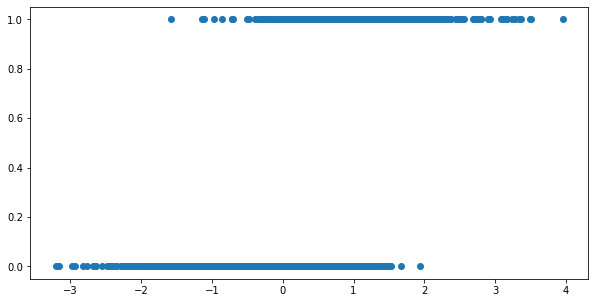

WCWS_in
0          1387
1           384
dtype: int64
Proportion 0:  0.7831733483907397


In [14]:
plt.scatter(X_famd_ext['0'],y_WSin)
plt.show()

print(y_WSin.value_counts())
print('Proportion 0: ', y_WSin.value_counts()[0]/len(y_WSin))

In [ ]:
w = y_WSin*(1387/384 - 1) + 1

In [15]:
logistic = LogisticRegression(C=1e4, solver='lbfgs', multi_class='auto',class_weight = None)
logistic.fit(X_famd_ext, y_WSin)
print('Train set score:', logistic.score(X_famd_ext, y_WSin))
print(confusion_matrix(y_WSin,logistic.predict(X_famd_ext)))

print('\n\nTest set score:', logistic.score(X_famd_2019_ext, y_WSin_2019))
print(confusion_matrix(y_WSin_2019,logistic.predict(X_famd_2019_ext)))

Train set score: 0.8966685488424618
[[1340   47]
 [ 136  248]]


Test set score: 0.8855218855218855
[[219  14]
 [ 20  44]]


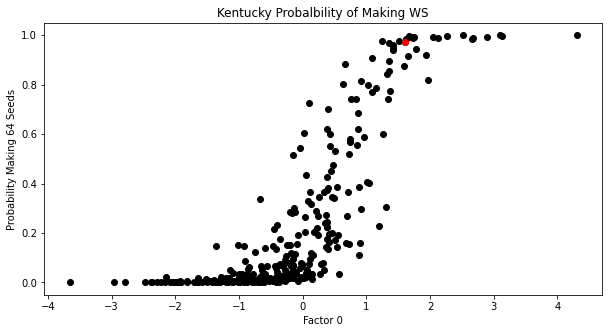

In [19]:
prob_in = logistic.predict_proba(X_famd_2019_ext)[:,1]

idx_ex = 15
college = X_College_2019.College.loc[idx_ex]
prob_college = prob_in[idx_ex]

plt.scatter(X_famd_2019_ext['0'],prob_in,color='k')
plt.scatter(X_famd_2019_ext['0'][idx_ex],prob_in[idx_ex],color='r')
plt.title(college + ' Probalbility of Making WS')
plt.ylabel('Probability Making 64 Seeds')
plt.xlabel('Factor 0')
plt.show()

In [20]:
# boostrap resampling to generate prediction probability
n_bootstrap = 100

y_ex = y_WSin_2019
X_ex = pd.DataFrame(X_famd_2019_ext)
scores = []
df_prob_in = pd.DataFrame()
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_WSin)), replace=True, n_samples=len(y_WSin))
    X_i = X_famd_ext.iloc[idx_resample]
    y_i = y_WSin.iloc[idx_resample]
    logistic.fit(X_i,y_i)
    idx_test = y_WSin.index[~y_WSin.index.isin(y_i.index)]
    scores.append(logistic.score(X_famd_ext.loc[idx_test],y_WSin.loc[idx_test]))
    prob_in_i = pd.DataFrame(logistic.predict_proba(X_famd_2019_ext)[:,1].reshape([1,-1])).round(decimals=2)
    df_prob_in = df_prob_in.append(prob_in_i,ignore_index = True)

df_prob_in.columns = X_College_2019.College

In [21]:
print(np.round(scores,decimals=3))
print(np.mean(scores))

[0.894 0.885 0.889 0.891 0.884 0.89  0.873 0.876 0.869 0.894 0.881 0.876
 0.886 0.886 0.882 0.873 0.889 0.866 0.885 0.851 0.883 0.863 0.894 0.871
 0.888 0.885 0.874 0.887 0.89  0.884 0.898 0.873 0.89  0.884 0.892 0.897
 0.882 0.877 0.865 0.854 0.863 0.875 0.884 0.898 0.889 0.895 0.882 0.888
 0.884 0.889 0.897 0.864 0.876 0.891 0.888 0.855 0.858 0.894 0.877 0.87
 0.9   0.885 0.884 0.877 0.866 0.881 0.873 0.884 0.868 0.879 0.873 0.866
 0.879 0.885 0.869 0.864 0.891 0.871 0.892 0.883 0.879 0.906 0.879 0.887
 0.883 0.885 0.866 0.875 0.866 0.878 0.869 0.882 0.868 0.87  0.883 0.868
 0.88  0.878 0.885 0.883]
0.880073387135468


In [91]:
df_prob_in.to_csv('WS64Seeds/WS64_prediction_logistic_ext.csv',index = False)
df_prob_in

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.83,0.77,1.00,0.99,0.98,0.99,0.99,0.93,0.98,1.00,0.98,0.91,0.95,0.68,0.83,0.98,0.97,0.99,0.90,1.00,0.92,0.83,0.35,0.62,0.67,0.99,0.26,0.37,0.48,0.89,0.58,0.68,0.14,0.20,0.18,0.82,0.91,0.56,0.51,0.83,0.15,0.05,0.54,0.54,0.60,0.19,0.23,0.17,0.87,0.73,0.01,0.32,0.44,0.65,0.23,0.32,0.06,0.32,0.64,0.09,0.70,0.59,0.08,0.02,0.84,0.22,0.55,0.02,0.47,0.47,0.21,0.21,0.32,0.92,0.23,0.04,0.25,0.05,0.25,0.09,0.24,0.22,0.38,0.19,0.22,0.19,0.19,0.12,0.45,0.38,0.58,0.01,0.01,0.03,0.15,0.39,0.04,0.08,0.43,0.28,0.03,0.01,0.09,0.01,0.72,0.09,0.14,0.54,0.01,0.04,0.01,0.03,0.61,0.06,0.10,0.01,0.07,0.30,...,0.09,0.00,0.11,0.07,0.02,0.06,0.00,0.00,0.05,0.01,0.18,0.03,0.00,0.09,0.00,0.37,0.01,0.0,0.12,0.0,0.05,0.00,0.00,0.06,0.01,0.04,0.0,0.29,0.01,0.35,0.01,0.01,0.01,0.27,0.0,0.06,0.01,0.11,0.12,0.02,0.45,0.01,0.00,0.00,0.25,0.01,0.05,0.00,0.07,0.01,0.00,0.02,0.0,0.01,0.0,0.0,0.00,0.35,0.03,0.01,0.06,0.00,0.02,0.00,0.00,0.00,0.04,0.04,0.01,0.00,0.03,0.15,0.01,0.04,0.37,0.02,0.00,0.0,0.00,0.00,0.00,0.07,0.01,0.01,0.00,0.00,0.03,0.00,0.00,0.05,0.0,0.00,0.28,0.01,0.09,0.0,0.01,0.02,0.01,0.0,0.03,0.00,0.00,0.01,0.0,0.00,0.04,0.04,0.03,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.03,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1,1.00,1

In [102]:
df_prob_in_5 = (df_prob_in*100/5).round(0)*5

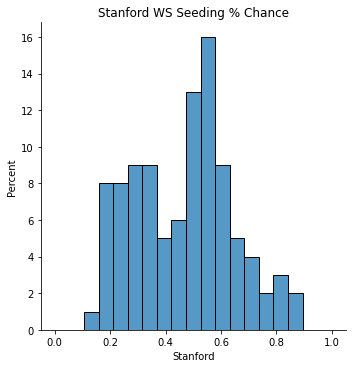

Actual result:  1
Predicted result (% peak chance making into WS):  55.0


In [104]:
idx_ex = 30
college = df_prob_in.columns[idx_ex]
bins = np.linspace(0,1,20)
sn.displot(data=df_prob_in,x=college,kde=False,bins=bins) 
plt.title(college + ' WS Seeding % Chance')
plt.ylabel('Percent')
plt.show()
print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())

### SGD Classifier

In [22]:
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-6,
              validation_fraction=0.1, verbose=0, warm_start=False)
sgd

SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0, tol=1e-06)

0.8932636928289103


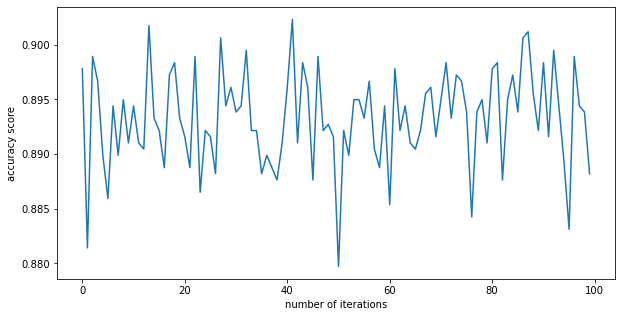

In [23]:
n_bootstrap = 100

scores_binary = []
df_prob_in = pd.DataFrame()
for i in range(n_bootstrap):
    sgd.fit(X_famd_ext, y_WSin)
    scores_binary.append(sgd.score(X_famd_ext, y_WSin))
    prob_in_i = pd.DataFrame(sgd.predict_proba(X_famd_2019_ext)[:,1].reshape([1,-1])).round(decimals=2)
    df_prob_in = df_prob_in.append(prob_in_i,ignore_index = True)
    
df_prob_in.columns = X_College_2019.College

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

SGD with logistic regression performs the best.

In [24]:
df_prob_in.to_csv('WS64Seeds/WS64_prediction_SGDlogistic_ext.csv',index = False)
df_prob_in_5 = (df_prob_in*100/5).round(0)*5
df_prob_in

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,1.0,1.00,1.0,0.99,1.00,0.99,0.93,0.93,0.99,1.00,0.98,0.99,0.99,0.88,0.96,0.99,0.99,0.91,0.95,0.35,0.56,0.95,0.96,0.99,0.88,0.99,0.89,0.92,0.27,0.40,0.58,0.97,0.07,0.73,0.46,0.75,0.88,0.82,0.08,0.22,0.23,0.53,0.91,0.83,0.46,0.98,0.28,0.15,0.44,0.31,0.63,0.20,0.46,0.19,0.87,0.89,0.03,0.22,0.32,0.54,0.15,0.50,0.10,0.43,0.63,0.31,0.70,0.83,0.04,0.03,0.86,0.11,0.73,0.02,0.76,0.54,0.14,0.26,0.19,0.85,0.17,0.05,0.15,0.02,0.11,0.02,0.04,0.24,0.15,0.09,0.15,0.40,0.15,0.26,0.19,0.35,0.72,0.03,0.01,0.03,0.16,0.29,0.02,0.33,0.20,0.71,0.02,0.01,0.26,0.01,0.41,0.14,0.05,0.13,0.01,0.04,0.02,0.06,0.27,0.04,0.05,0.00,0.14,0.22,...,0.16,0.01,0.02,0.15,0.03,0.03,0.00,0.00,0.02,0.01,0.22,0.01,0.01,0.03,0.0,0.03,0.01,0.00,0.09,0.0,0.05,0.01,0.00,0.01,0.01,0.01,0.0,0.04,0.00,0.49,0.01,0.00,0.00,0.22,0.0,0.04,0.00,0.16,0.04,0.01,0.26,0.00,0.0,0.00,0.65,0.10,0.03,0.01,0.05,0.01,0.0,0.05,0.0,0.07,0.0,0.0,0.0,0.11,0.02,0.01,0.04,0.00,0.01,0.00,0.00,0.00,0.16,0.06,0.01,0.00,0.01,0.07,0.01,0.03,0.14,0.01,0.00,0.0,0.00,0.01,0.00,0.04,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.28,0.0,0.0,0.04,0.01,0.03,0.0,0.03,0.01,0.00,0.0,0.01,0.01,0.00,0.01,0.00,0.00,0.03,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.01,0.0,0.0
1,1.0,1.0,1.00

In [25]:
df_prob_in_rank = df_prob_in.rank(axis=1, ascending=False)
df_prob_in_rank = df_prob_in_rank <= 64
df_prob_in_rank = df_prob_in_rank.astype(int)
mean_prob = df_prob_in_rank.mean()
df_WSin_odds = pd.DataFrame(mean_prob/(1-mean_prob)).T
df_WSin_odds[df_WSin_odds > 100] = 100
df_WSin_meanProb = pd.DataFrame(df_prob_in_rank.mean()).T
df_WSin_meanProb

College,Oklahoma,UCLA,Washington,Arizona,Florida State,Alabama,Minnesota,Texas,Oklahoma State,Florida,James Madison,Northwestern,LSU,Michigan,Ole Miss,Kentucky,Tennessee,ULL,Texas Tech,Auburn,North Carolina,Drake,South Carolina,Arizona State,Georgia,Missouri,Virginia Tech,Mississippi State,Wisconsin,Tulsa,Stanford,South Florida,Arkansas,Louisville,Boise State,Houston,Notre Dame,Colorado State,Ohio State,Lipscomb,Illinois,Oregon State,Southern Ill.,Louisiana Tech,UNLV,CSU Fullerton,North Dakota State,Iowa State,San Jose State,Texas A&M,UCF,Indiana,UT Arlington,North Texas,Liberty,Seattle U,WKU,Baylor,Southeast Mo. State,Oregon,Wichita State,Sam Houston State,Fresno State,Texas State,Troy,California,LMU (CA),UC Davis,Marshall,Longwood,Elon,New Mexico State,UNCG,Grand Canyon,Kent State,Coastal Carolina,DePaul,Jacksonville State,Miami (OH),Long Beach State,USC Upstate,Nicholls State,FGCU,NC State,McNeese State,Bradley,Missouri State,Duke,Rutgers,Georgia Tech,Eastern Ky.,Purdue,Hawaii,UNI,Nevada,Chattanooga,Boston U,Southern Miss.,San Diego State,Utah,Nebraska,Ohio,Austin Peay,North Florida,BYU,SFA,South Dakota State,Weber State,North Ala.,Appalachian State,Iowa,Stony Brook,State John's (NY),UMass Lowell,George Washington,Virginia,Toledo,Northern Ill.,FIU,LIU,Towson,Belmont,Maryland,Ball State,UIC,...,Ga. Southern,UTEP,Gardner-Webb,Creighton,Seton Hall,UT Martin,Lamar University,Pittsburgh,Houston Baptist,Western Mich.,Marist,ETSU,Tennessee Tech,UMBC,SIUE,Florida A&M,Colgate,Cal Poly,Columbia,Charlotte,Detroit Mercy,Jacksonville,Statetson,Central Ark.,Idaho State,Dayton,Furman,Bethune-Cookman,Binghamton,California Baptist,Bowling Green,Indiana State,Saint Louis,UMKC,La.-Monroe,Portland State,Charleston So.,Drexel,Army West Point,George Mason,Penn,Evansville,Valparaiso,Western Caro.,Prairie View,Texas Southern,Montana,Pacific,Fairfield,Utah Valley,Eastern Ill.,Butler,Georgetown,North Dakota,Tennessee State,Georgia State,Abilene Christian,Sacred Heart,Siena,Dartmouth,Youngstown State,Northern Colo.,Northern Ky.,Hampton,Saint Mary's (CA),UC Santa Barbara,Alabama State,Iona,San Diego,Santa Clara,Bryant,Mount State Mary's,Princeton,Manhattan,Norfolk State,Wright State,Hartford,A&M-Corpus Christi,IUPUI,Purdue Fort Wayne,Maine,Yale,Oakland,CSU Bakersfield,Canisius,Buffalo,Rhode Island,Akron,Robert Morris,Alabama A&M,UIW,Presbyterian,N.C. Central,Niagara,Central Conn. State,Wagner,Alcorn,Holy Cross,Cleveland State,Omaha,Morgan State,Green Bay,Mississippi Val.,Quinnipiac,Lafayette,Jackson State,Brown,Howard,Fairleigh Dickinson,La Salle,Morehead State,Cornell,N.C. A&T,Delaware State,Rider,Southern Utah,Coppin State,Savannah State,State Bonaventure,Grambling,Ark.-Pine Bluff,UMES,Southern U.,Saint Peter's,South Carolina State
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.89,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.65,1.0,1.0,0.01,0.92,1.0,1.0,1.0,1.0,0.0,0.06,0.07,0.95,1.0,1.0,0.83,1.0,0.06,0.0,0.9,0.41,1.0,0.0,0.12,0.2,1.0,1.0,0.0,0.14,0.07,1.0,0.03,0.47,0.0,0.05,0.99,0.31,1.0,0.96,0.0,0.0,0.94,0.01,0.87,0.0,0.53,0.12,0.0,0.36,0.01,1.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.51,0.02,0.0,0.28,0.88,0.92,0.0,0.0,0.0,0.02,0.32,0.0,0.26,0.09,0.03,0.0,0.0,0.0,0.0,0.9,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.29,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


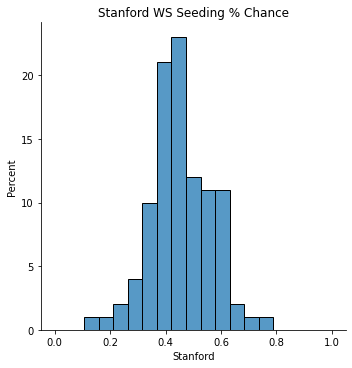

Actual result:  1
Average percent chance making into WS (%): 65.0
Odds making into WS (100 max, >1 indicates greater odds making):  1.86
Predicted result (% peak chance making into WS):  45.0


In [27]:
idx_ex = 30
college = df_prob_in.columns[idx_ex]
bins = np.linspace(0,1,20)
sn.displot(data=df_prob_in,x=college,kde=False,bins=bins) 
plt.title(college + ' WS Seeding % Chance')
plt.ylabel('Percent')
plt.show()
print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
print('Average percent chance making into WS (%):', np.round(df_WSin_meanProb[college][0]*100))
print('Odds making into WS (100 max, >1 indicates greater odds making): ', np.round(df_WSin_odds[college][0],decimals=2))
print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())

In [231]:
'''
idx_ex = 30
college = df_prob_in.columns[idx_ex]
bins = np.linspace(0,1,20)
sn.displot(data=df_prob_in,x=college,kde=False,bins=bins) 
plt.title(college + ' WS Seeding % Chance')
plt.ylabel('Percent')
plt.show()
print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
print('Average percent chance making into WS (%):', np.round(df_WSin_meanProb[college][0]*100))
print('Odds making into WS (100 max, >1 indicates greater odds making): ', np.round(df_WSin_odds[college].mean(),decimals=2))
print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())
'''

"\nidx_ex = 30\ncollege = df_prob_in.columns[idx_ex]\nbins = np.linspace(0,1,20)\nsn.displot(data=df_prob_in,x=college,kde=False,bins=bins) \nplt.title(college + ' WS Seeding % Chance')\nplt.ylabel('Percent')\nplt.show()\nprint('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])\nprint('Average percent chance making into WS (%):', np.round(df_WSin_meanProb[college][0]*100))\nprint('Odds making into WS (100 max, >1 indicates greater odds making): ', np.round(df_WSin_odds[college].mean(),decimals=2))\nprint('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())\n"

In [206]:
'''
df_WSin_binary = pd.DataFrame(df_prob_in.mean().rank(ascending=False))
df_WSin_binary[df_WSin_binary <= 64] = 1
df_WSin_binary[df_WSin_binary > 64] = 0
df_WSin_binary.sum(axis=0)
'''

0    64.0
dtype: float64

In [28]:
df_WSin_binary = pd.DataFrame(df_WSin_meanProb.rank(axis=1,ascending=False)).T
df_WSin_binary[df_WSin_binary <= 64] = 1
df_WSin_binary[df_WSin_binary > 64] = 0
df_WSin_binary.sum(axis=0)

0    64.0
dtype: float64

In [30]:
print(confusion_matrix(y_WSin_2019,df_WSin_binary))
print('Accuracy(%): ', (214+45)/(214+45+38)*100)

[[214  19]
 [ 19  45]]
Accuracy(%):  87.20538720538721


### Support Vector Machine Classifier with SGD

0.886465273856578


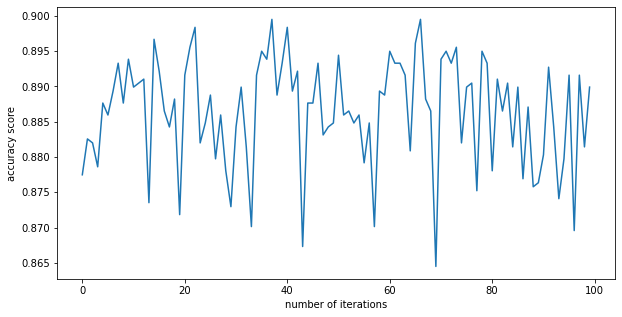

In [127]:
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='hinge', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-6,
              validation_fraction=0.1, verbose=0, warm_start=False)

scores_binary = []
n_bootstrap = 100
for i in range(n_bootstrap):
    sgd.fit(X_famd, y_WSin)
    scores_binary.append(sgd.score(X_famd, y_WSin))

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

0.8598870694522865


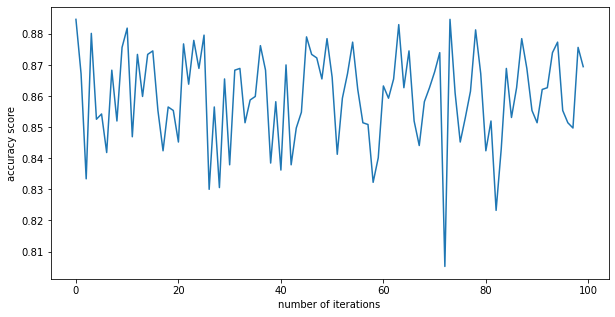

In [128]:
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='modified_huber', max_iter=10000.0,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=1e-6,
              validation_fraction=0.1, verbose=0, warm_start=False)

scores_binary = []
n_bootstrap = 100
for i in range(n_bootstrap):
    sgd.fit(X_famd, y_WSin)
    scores_binary.append(sgd.score(X_famd, y_WSin))

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))

0.8798314110052701


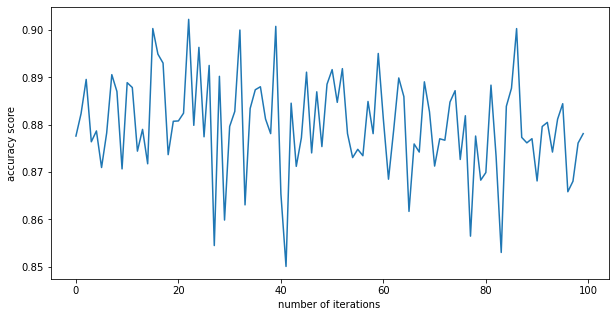

In [134]:
lin_clf = svm.LinearSVC(class_weight=None)
lin_clf.fit(X_famd, y_WSin)

scores_binary = []
n_bootstrap = 100
for i in range(n_bootstrap):
    idx_resample =  resample(range(len(y_WSin)), replace=True, n_samples=len(y_WSin))
    X_i = X_famd.iloc[idx_resample]
    y_i = y_WSin.iloc[idx_resample]
    lin_clf.fit(X_i,y_i)
    idx_test = y_WSin.index[~y_WSin.index.isin(y_i.index)]
    scores_binary.append(lin_clf.score(X_famd.loc[idx_test],y_WSin.loc[idx_test]))

plt.plot(range(n_bootstrap), scores_binary) 
plt.xlabel('number of iterations')
plt.ylabel('accuracy score')

print(np.mean(scores_binary))